### Loading the multi-view reasoning category of blink

In [6]:
from datasets import load_dataset

dataset_name = 'BLINK-Benchmark/BLINK'
data = load_dataset(dataset_name, 'Multi-view_Reasoning')

In [7]:
data_val = data['val']
print(data_val)
data_test = data['test']

print(data_val[0]['question'])
print(data_val[0]['sub_task'])
print(data_val[0]['image_1'])

print(data_val[0]['choices'])
print(data_val[0]['answer'])

Dataset({
    features: ['idx', 'question', 'sub_task', 'image_1', 'image_2', 'image_3', 'image_4', 'choices', 'answer', 'prompt', 'explanation'],
    num_rows: 133
})
The images are frames from a video. The first image is from the beginning of the video and the second image is from the end. Is the camera moving left or right when shooting the video? Select between A and B.
Multi-view Reasoning
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x640 at 0x1F497952C40>
['left', 'right']
(B)


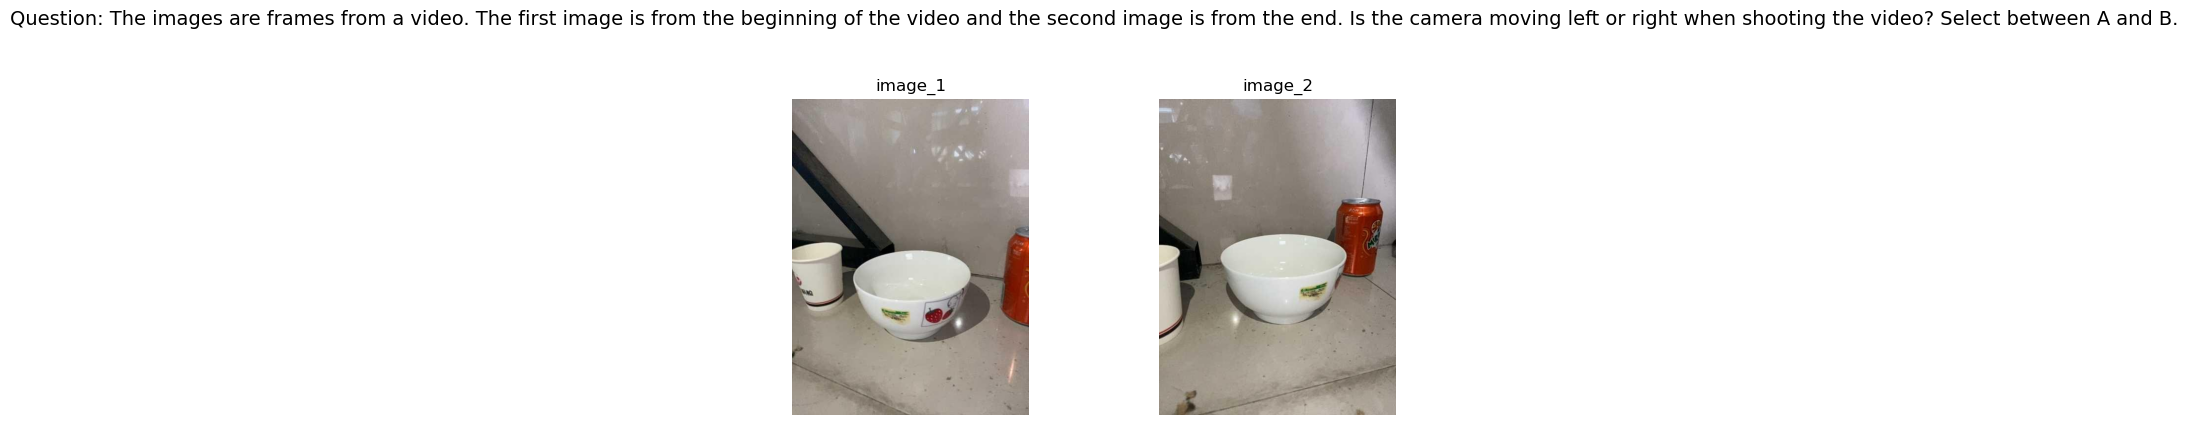

Prompt: The images are frames from a video. The video is shooting a static scene. The camera is either moving clockwise (left) or counter-clockwise (right) around the object. The first image is from the beginning of the video and the second image is from the end. Is the camera moving left or right when shooting the video? Select from the following options.
(A) left
(B) right
Choices:
  A. left
  B. right

Correct Answer: (A)


In [8]:
import matplotlib.pyplot as plt

def show_question_with_images(data, index):
    example = data[index]
    image_keys = ['image_1', 'image_2', 'image_3', 'image_4']
    
    images = [(key, example[key]) for key in image_keys if example[key] is not None]
    
    # display images in a row
    fig, axes = plt.subplots(1, len(images), figsize=(4 * len(images), 4))
    if len(images) == 1:
        axes = [axes]  
    for ax, (label, img) in zip(axes, images):
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    
    plt.suptitle(f"Question: {example['question']}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

    # show choices and correct answer
    print("Prompt:", example["prompt"])
    print("Choices:")
    for i, choice in enumerate(example['choices']):
        print(f"  {chr(65 + i)}. {choice}")
    print("\nCorrect Answer:", example['answer'])

    if example.get('explanation'):
        print("\nExplanation:", example['explanation'])

show_question_with_images(data_val, 3)



### Loading the LoFTR model

In [9]:
# !pip install kornia

import kornia as K
import kornia.feature as KF
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
matcher = KF.LoFTR(pretrained='outdoor').to(device)
matcher.eval()

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

In [11]:
def prepare_image(pil_image, device, transform):
    return transform(pil_image).unsqueeze(0).to(device)

@torch.no_grad()
def estimate_motion_direction(img0_tensor, img1_tensor, matcher):
    batch = {
        'image0': img0_tensor,
        'image1': img1_tensor
    }

    correspondences = matcher(batch)

    if correspondences['keypoints0'].shape[0] < 1:
        return 'unknown'

    # Average x displacement
    x0 = correspondences['keypoints0'][:, 0]
    x1 = correspondences['keypoints1'][:, 0]
    avg_dx = (x1 - x0).mean().item()

    # (B) stands for right, (A) stands for left
    return '(B)' if avg_dx > 0 else '(A)'

### Evaluate outdoor model

In [ ]:
def evaluate(data, matcher):
    correct = 0
    total = 0

    for sample in data:
        img1 = prepare_image(sample['image_1'], device, transform)
        img2 = prepare_image(sample['image_2'], device, transform)

        pred = estimate_motion_direction(img1, img2, matcher)
        gt = sample['answer']
        pred_direction = 'left' if pred == '(A)' else 'right'
        gt_direction = 'left' if gt == '(A)' else 'right'

        print("Predicted answer : ", pred, " ", pred_direction)
        print("Correct answer : ", gt, " ", gt_direction)
        if pred == gt:
            correct += 1
        total += 1
    
    accuracy = correct / total
    return accuracy


accuracy = evaluate(data_val, matcher)
print(f"LoFTR outdoor direction accuracy: {accuracy:.2%}")

Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (A)   left
Correct answer :  (A)   left
Predicted answer :  (A)   left
Correct answer :  (A)   left
Predicted answer :  (A)   left
Correct answer :  (A)   left
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (A)   left
Correct answer :  (A)   left
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (A)   left
Correct answer :  (A)   left
Predicted answer :  (A)   left
Correct answer :  (A)   left
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (B)   right
Correct answer :  (A)   left
Predicted answer :  (

### Evaluate indoor model

In [15]:
matcher = KF.LoFTR(pretrained='indoor').to(device)

accuracy = evaluate(data_val, matcher)
print(f"LoFTR indoor direction accuracy: {accuracy:.2%}")

Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (A)   left
Correct answer :  (A)   left
Predicted answer :  (A)   left
Correct answer :  (A)   left
Predicted answer :  (A)   left
Correct answer :  (A)   left
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (A)   left
Correct answer :  (A)   left
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (B)   right
Correct answer :  (A)   left
Predicted answer :  (A)   left
Correct answer :  (A)   left
Predicted answer :  (B)   right
Correct answer :  (B)   right
Predicted answer :  (A)   left
Correct answer :  (A)   left
Predicted answer :  (